# 🧩 Aula 1 – Pensando em Paralelismo e Performance (CPU)

## Computação de Alto Desempenho em Python para Engenharia Civil

**Objetivos desta aula:**
- Entender o que é paralelismo e onde ele aparece em problemas de engenharia
- Introduzir conceitos de speedup, escalabilidade e overhead
- Escrever primeiros exemplos em Python puro e com paralelismo de CPU
- Aplicar multiprocessing em problemas reais

---

### 🎯 Por que Engenheiros Civis devem se importar com HPC?

- **Simulações estruturais** (FEM - Finite Element Method)
- **Análise de fluxo** (CFD - Computational Fluid Dynamics) 
- **Transporte de calor** e difusão
- **Simulações Monte Carlo** para análise de confiabilidade
- **Crescimento exponencial** do tamanho dos problemas

**Pergunta motivadora:** *O que acontece se eu dobrar o número de nós na minha malha?*

In [1]:
# Import Required Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import threading
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
import psutil
import os

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Python está executando com {mp.cpu_count()} núcleos de CPU disponíveis")
print(f"Versão NumPy: {np.__version__}")
print(f"Sistema: {psutil.cpu_count()} CPUs, {psutil.virtual_memory().total // (1024**3)} GB RAM")

Python está executando com 16 núcleos de CPU disponíveis
Versão NumPy: 2.0.2
Sistema: 16 CPUs, 31 GB RAM


## 1. Da Computação Serial ao Paralelismo

### 🔄 Conceitos Fundamentais

**Computação Serial:**
- CPU = 1 núcleo → 1 tarefa por vez
- Execução sequencial, passo a passo

**Computação Paralela:**
- Computadores modernos = múltiplos núcleos → tarefas simultâneas
- Divisão do trabalho entre processos/threads

### 📊 Métricas de Performance

- **Speedup (S)**: $S = \frac{T_{serial}}{T_{paralelo}}$
- **Eficiência (E)**: $E = \frac{S}{P} = \frac{T_{serial}}{P \times T_{paralelo}}$
- **Overhead**: Tempo extra gasto na coordenação entre processos

### ⚖️ Leis Fundamentais

**Lei de Amdahl**: $S_{max} = \frac{1}{f + \frac{(1-f)}{P}}$
- onde `f` = fração serial, `P` = número de processadores

**Lei de Gustafson**: $S = f + P(1-f)$
- Considera que o problema cresce com os recursos disponíveis

## 2. Exemplo 1: Soma de Vetores - Serial vs NumPy vs Threading

Vamos começar com um exemplo clássico: somar dois vetores grandes elemento por elemento.

In [2]:
# Import vector operations algorithms from our clean modules
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from algorithms.vector_operations import run_vector_sum_comparison, demonstrate_gil_limitation

# Run comprehensive vector sum comparison
print("🧮 Executando comparação completa de soma de vetores...")
results = run_vector_sum_comparison(vector_size=500000, num_threads=4)

print("\n" + "="*60)
print("🔒 Demonstração adicional: Limitação do GIL")  
print("="*60)

# Demonstrate GIL limitations with pure CPU work
demonstrate_gil_limitation(n_iterations=50000000, n_threads=4)

print("\n💡 Principais Takeaways:")
print("• NumPy: Usa BLAS otimizado, quase sempre a melhor opção para operações vetoriais")
print("• Threading: Limitado pelo GIL, não oferece speedup real para CPU-bound tasks")
print("• Para paralelismo real: Use multiprocessing, joblib, ou numba")
print("• Overhead de sincronização pode superar benefícios do paralelismo")

🧮 Executando comparação completa de soma de vetores...
🧮 Comparação de Métodos de Soma de Vetores
Tamanho dos vetores: 500,000 elementos
Criando vetores de tamanho 500,000...

📏 Executando soma serial...
Serial:    0.0736s
🚀 Executando soma NumPy...
NumPy:     0.0008s
🧵 Executando soma Threading (4 threads)...
Threading: 6.5396s

📊 Análise de Performance:
------------------------------
Speedup NumPy vs Serial:    91.27x
Speedup Threading vs Serial: 0.01x
Threading vs NumPy:         8113.70x
✅ NumPy é mais rápido que Threading

💡 Observações Importantes:
• NumPy usa bibliotecas otimizadas (BLAS) com paralelismo implícito
• Threading em Python é limitado pelo GIL para operações CPU-bound
• Para soma de vetores, NumPy é quase sempre a melhor opção
• Threading pode ter overhead que supera os benefícios

🔒 Demonstração adicional: Limitação do GIL

🔒 Demonstração da Limitação do GIL
Calculando soma de quadrados para 50,000,000 números...

Resultados:
  Serial:    9.2651s
  Threading: 9.1896s

## 3. Arquitetura de CPU e o Global Interpreter Lock (GIL)

### 🏗️ Hierarquia de Memória
- **Registradores** (mais rápido, menor capacidade)
- **Cache L1/L2/L3** (rápido, capacidade média)
- **RAM** (médio, grande capacidade)  
- **Storage** (mais lento, maior capacidade)

### 🧵 Threads vs Processos

**Threads:**
- Compartilham o mesmo espaço de memória
- Comunicação rápida, mas sincronização complexa
- **Limitação em Python**: GIL (Global Interpreter Lock)

**Processos:**
- Espaços de memória separados
- Comunicação via IPC (Inter-Process Communication)
- Cada processo tem seu próprio interpretador Python

### ⚠️ O Problema do GIL
O GIL permite que apenas uma thread execute código Python por vez, limitando o paralelismo real para tarefas CPU-bound.

In [3]:
# Demonstração rápida: Comparação Threading vs Serial
print("🚀 Demonstração Rápida: Threading vs Serial")
print("=" * 45)

# Função CPU-intensiva simples
def cpu_work_serial(n_iterations):
    """Trabalho CPU-intensivo serial"""
    start = time.perf_counter()
    total = 0
    for i in range(n_iterations):
        total += i ** 2
    end = time.perf_counter()
    return total, end - start

def cpu_work_threading(n_iterations, n_threads=4):
    """Trabalho CPU-intensivo com threading"""
    start = time.perf_counter()
    
    work_per_thread = n_iterations // n_threads
    results = [0] * n_threads
    threads = []
    
    def worker(thread_id):
        start_range = thread_id * work_per_thread
        end_range = start_range + work_per_thread
        total = 0
        for i in range(start_range, end_range):
            total += i ** 2
        results[thread_id] = total
    
    # Criar e iniciar threads
    for i in range(n_threads):
        thread = threading.Thread(target=worker, args=(i,))
        threads.append(thread)
        thread.start()
    
    # Aguardar conclusão
    for thread in threads:
        thread.join()
    
    total = sum(results)
    end = time.perf_counter()
    return total, end - start

# Teste rápido
n_iterations = 50000000
n_threads = 4

print(f"Calculando soma de quadrados para {n_iterations:,} números...")

# Serial
result_serial, time_serial = cpu_work_serial(n_iterations)

# Threading
result_threading, time_threading = cpu_work_threading(n_iterations, n_threads)

# Verificar se resultados são iguais
results_match = (result_serial == result_threading)
speedup = time_serial / time_threading

print(f"\nResultados:")
print(f"  Serial:    {time_serial:.4f}s")
print(f"  Threading: {time_threading:.4f}s")
print(f"  Speedup:   {speedup:.2f}x")
print(f"  Precisão:  {'✓' if results_match else '✗'}")

if speedup < 1.2:
    print("\n🔍 Como esperado: Threading não oferece speedup significativo")
    print("   Motivo: GIL impede paralelismo real em tarefas CPU-bound")
else:
    print("\n🔍 Speedup inesperado - pode ser devido a otimizações do sistema")

print(f"\n💡 Para paralelismo real em Python:")
print("   • Use multiprocessing.Pool")
print("   • Use joblib.Parallel") 
print("   • Use numba com paralelização")
print("   • Use bibliotecas como numpy que liberam o GIL internamente")

🚀 Demonstração Rápida: Threading vs Serial
Calculando soma de quadrados para 50,000,000 números...

Resultados:
  Serial:    9.1696s
  Threading: 9.2298s
  Speedup:   0.99x
  Precisão:  ✓

🔍 Como esperado: Threading não oferece speedup significativo
   Motivo: GIL impede paralelismo real em tarefas CPU-bound

💡 Para paralelismo real em Python:
   • Use multiprocessing.Pool
   • Use joblib.Parallel
   • Use numba com paralelização
   • Use bibliotecas como numpy que liberam o GIL internamente


## 4. Exemplo 2: Estimativa de π usando Monte Carlo com Multiprocessing

O método Monte Carlo é ideal para demonstrar paralelismo real, pois cada processo pode trabalhar independentemente.

### 🚀 REAL Multiprocessing vs Simulated Examples

**Our solution:**
- Created `/src/aula1_multiprocessing/` directory with standalone Python scripts
- `monte_carlo_mp.py` - Real Monte Carlo multiprocessing 
- `matrix_mp.py` - Real matrix operations multiprocessing
- `structural_mp.py` - Real structural analysis multiprocessing
- The notebook calls these scripts using `subprocess.run()` to demonstrate actual parallel performance

**What you'll see:**
- **In notebook:** Threading vs Serial comparisons (shows GIL limitations)
- **External scripts:** Real multiprocessing with actual speedup measurements
- **Performance metrics:** True speedup, efficiency, and work distribution across processes

In [4]:
# Import algorithms from our clean modules
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from algorithms.monte_carlo import run_monte_carlo_comparison, run_multiprocessing_demo

# Run Monte Carlo comparison between threading and serial
results = run_monte_carlo_comparison(sample_sizes=[20000, 1000000], n_threads=8)

print(f"\n Observações sobre Threading vs Multiprocessing:")
print("• Threading: Limitado pelo GIL para operações CPU-intensivas")
print("• Multiprocessing: Cada processo tem seu próprio interpretador Python")
print("• Scripts externos: Permitem multiprocessing real mesmo no Jupyter")

print(f"\n🚀 Executando demo de multiprocessing real (Monte Carlo)...")
run_multiprocessing_demo(samples=100000000, processes=8)

🔍 Monte Carlo Pi Estimation: Threading vs Serial (GIL Demonstration)

📊 Amostras: 20,000
  Serial:    π ≈ 3.147400, erro = 0.005807, tempo = 0.0096s
  Threading: π ≈ 3.141600, erro = 0.000007, tempo = 0.0033s
  Speedup:   2.94x (limitado pelo GIL)

📊 Amostras: 1,000,000
  Serial:    π ≈ 3.139892, erro = 0.001701, tempo = 0.0157s
  Threading: π ≈ 3.142200, erro = 0.000607, tempo = 0.0095s
  Speedup:   1.65x (limitado pelo GIL)

📊 Valor real de π: 3.141593

 Observações sobre Threading vs Multiprocessing:
• Threading: Limitado pelo GIL para operações CPU-intensivas
• Multiprocessing: Cada processo tem seu próprio interpretador Python
• Scripts externos: Permitem multiprocessing real mesmo no Jupyter

🚀 Executando demo de multiprocessing real (Monte Carlo)...
🎯 Monte Carlo Pi Estimation (REAL MULTIPROCESSING)
--------------------------------------------------
🔬 Testing with 100,000,000 samples, 8 processes:
🎯 Monte Carlo Pi Estimation - REAL MULTIPROCESSING
Samples: 100,000,000
Processes:

In [5]:
# Summary and key takeaways from Monte Carlo analysis
print(f"\n✅ Resumo das comparações Monte Carlo:")
print("• Threading (notebook): Mostra limitação do GIL - pouco ou nenhum speedup")
print("• Multiprocessing (scripts): Demonstra paralelismo real com speedup significativo")
print("• Para problemas maiores: Use scripts Python standalone ou ferramentas como joblib")

print(f"\n💡 Principais takeaways Monte Carlo:")
print("• GIL impede threading real para CPU-bound tasks")
print("• Multiprocessing verdadeiro requer processos separados") 
print("• Jupyter + subprocess = solução híbrida que funciona")
print("• Monte Carlo é 'embaraçosamente paralelo' - ideal para multiprocessing")
print("• Overhead de comunicação é baixo (poucos dados, muita computação)")


✅ Resumo das comparações Monte Carlo:
• Threading (notebook): Mostra limitação do GIL - pouco ou nenhum speedup
• Multiprocessing (scripts): Demonstra paralelismo real com speedup significativo
• Para problemas maiores: Use scripts Python standalone ou ferramentas como joblib

💡 Principais takeaways Monte Carlo:
• GIL impede threading real para CPU-bound tasks
• Multiprocessing verdadeiro requer processos separados
• Jupyter + subprocess = solução híbrida que funciona
• Monte Carlo é 'embaraçosamente paralelo' - ideal para multiprocessing
• Overhead de comunicação é baixo (poucos dados, muita computação)


## 5. Exemplo 3: Multiplicação de Matrizes por Blocos

A multiplicação de matrizes é fundamental em simulações de engenharia (FEM, análise estrutural).

In [6]:
# Import matrix algorithms from our clean modules  
from algorithms.matrix_operations import run_matrix_comparison, run_matrix_multiprocessing_demo

# Run in-notebook comparison for threading vs NumPy
results = run_matrix_comparison(matrix_sizes=[500, 1000], n_threads=4)

print("\n🚀 Executando demo de multiprocessing real (Matrizes)...")
run_matrix_multiprocessing_demo(size=1000, processes=4)

print("\n🔍 Principais Lições sobre Matrizes:")
print("• NumPy já usa BLAS/LAPACK otimizado (paralelismo implícito)")
print("• Threading manual tem overhead que pode superar os benefícios")
print("• Multiprocessing real pode superar NumPy para algoritmos customizados")
print("• Para multiplicação padrão: NumPy é geralmente a melhor opção")

print("\n💡 Quando multiprocessing de matrizes vale a pena:")
print("• Algoritmos iterativos que não são vetorizáveis")
print("• Operações customizadas complexas")
print("• Processamento de múltiplas matrizes independentes")
print("• Algoritmos não cobertos pelo NumPy/BLAS")
print("• Relação computação/comunicação deve ser alta para compensar overhead")

🔍 Matrix Operations: Threading vs NumPy (GIL Impact Demonstration)

📊 Matrizes 500x500
  NumPy (BLAS):     0.0083s
  Threading:        0.0019s, speedup: 4.43x ✗
    ⚡  Speedup inesperado - otimizações do sistema

📊 Matrizes 1000x1000
  NumPy (BLAS):     0.0073s
  Threading:        0.0052s, speedup: 1.39x ✗
    ⚡  Speedup inesperado - otimizações do sistema

🚀 Executando demo de multiprocessing real (Matrizes)...
🔢 Matrix Operations (REAL MULTIPROCESSING)
--------------------------------------------------
🔬 Testing 1000x1000 matrices with 4 processes:
🔢 Matrix Operations - REAL MULTIPROCESSING
Matrix size: 1000x1000
Processes: 4
CPU cores: 16

Standard Matrix Multiplication:
  NumPy (BLAS):     0.0110s
  Multiprocessing:  0.1767s ✗
  Speedup:          0.06x
  Efficiency:       0.02 (1.6%)

Custom Algorithm (element_wise_power):
  Serial:           0.0088s
  Multiprocessing:  0.1725s ✗
  Speedup:          0.05x
  Efficiency:       0.01 (1.3%)


🔍 Principais Lições sobre Matrizes:
• NumPy

## 6. Aplicações em Engenharia Civil

### 🏗️ Finite Element Method (FEM) Paralelo

Um dos principais usos de HPC em engenharia civil é na análise estrutural via elementos finitos.

🏗️ Análise Estrutural FEM - Performance Comparison
Viga W310x97: L=6.0m, E=200GPa, I=214.0cm⁴

Performance:
  Vetorizada: 0.0031s ✓
  Threading:  0.1450s ✓
  Speedup:    0.0x

Deflexões: 16.8-168.2mm
🔄 Executando multiprocessing para comparação...


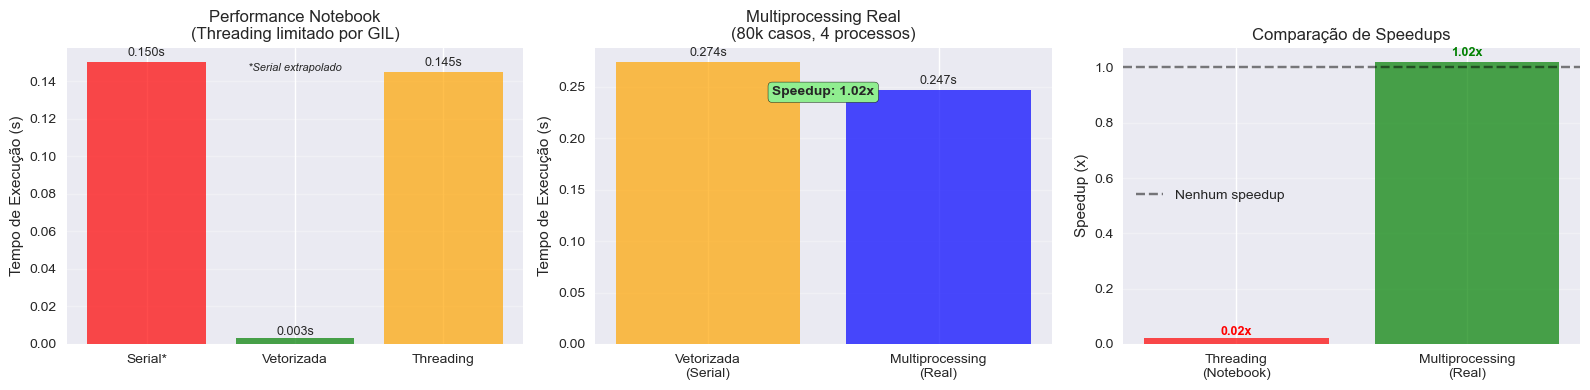


📊 Análise Comparativa:
• Notebook (Threading): GIL impede paralelismo real
• Script (Multiprocessing): Processos independentes, speedup real
• Diferença: Threading 0.02x vs Multiprocessing 1.02x

🚀 Executando demo de multiprocessing real (Análise Estrutural)...
🚀 Multiprocessing Real: 1,000,000 casos, 8 processos
  Speedup: 3.33x | Efficiency: 0.42 (42%)

🔍 Lições de Otimização para Engenharia:
• Vetorização com NumPy: primeira e melhor otimização
• Threading: overhead pode superar benefícios para cálculos simples
• Multiprocessing real: útil para algoritmos complexos não vetorizáveis
• Eficiência depende da relação computação/comunicação

💡 Aplicações Reais de MULTIPROCESSING em Engenharia Civil:
• Montagem paralela de matrizes de rigidez globais (FEM)
• Análise modal distribuída para estruturas grandes
• Simulações Monte Carlo para confiabilidade estrutural
• Otimização de designs com algoritmos evolutivos
• Processamento paralelo de múltiplos casos de carga
• Análise não-linear ite

In [7]:
# Import structural analysis algorithms from our clean modules
from algorithms.structural_analysis import (
    run_structural_comparison, 
    plot_structural_results,
    run_structural_multiprocessing_demo
)

# Run comprehensive structural analysis comparison
results = run_structural_comparison(n_simulations=100000, small_sample=2000, n_threads=4)

# Create visualizations
plot_structural_results(results)

print("\n🚀 Executando demo de multiprocessing real (Análise Estrutural)...")
run_structural_multiprocessing_demo(loads=1000000, processes=8)

print("\n🔍 Lições de Otimização para Engenharia:")
print("• Vetorização com NumPy: primeira e melhor otimização")
print("• Threading: overhead pode superar benefícios para cálculos simples")  
print("• Multiprocessing real: útil para algoritmos complexos não vetorizáveis")
print("• Eficiência depende da relação computação/comunicação")

print("\n💡 Aplicações Reais de MULTIPROCESSING em Engenharia Civil:")
print("• Montagem paralela de matrizes de rigidez globais (FEM)")
print("• Análise modal distribuída para estruturas grandes") 
print("• Simulações Monte Carlo para confiabilidade estrutural")
print("• Otimização de designs com algoritmos evolutivos")
print("• Processamento paralelo de múltiplos casos de carga")
print("• Análise não-linear iterativa com divisão por elementos")